In [1]:
#my model overfitted on the MNIST-style digits, which results in it only recognizing digits 
#from the dataset, but not from another source with a slightly different drawing style

In [2]:
#there exist models that can recognise virtually any type of image style of digits, but they have been trained on a lot more such data.
#if my FFN had learnt concepts in human terms then the MNIST-style would not impact accuracy, yet my FFN is not a conceptual learner, neither are any of the deeper more general models out there.

In [3]:
#just show failure at different-style, surely it alredy exists in literature, use that too

In [4]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import random as ra

from skimage.morphology import skeletonize
import networkx as nx
from scipy.ndimage import distance_transform_edt

import os
import re

In [5]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16
out_size = 10

epochs = 10
batch_size = 1000 #just for loading more data easily
learning_rate = 0.001

In [6]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [7]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)     #784 - 32
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)   #32 - 16
        self.fc2 = nn.Linear(hidden_size1, out_size)       #16 - 10
        self.tanh = nn.Tanh()
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.fc0.weight, gain=nn.init.calculate_gain('tanh')) 
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('tanh'))

    def forward(self, x):
        x0 = self.tanh(self.fc0(x))
        x1 = self.tanh(self.fc1(x0))
        out = self.fc2(x1)
        return out, [x0, x1, out]

In [8]:
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

net.load_state_dict(torch.load('02_ffn_mnist_full.pth'))

<All keys matched successfully>

In [9]:
with torch.no_grad():
    correct = 0
    for images, labels in test_loader:
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
        images = images.view(-1, 28*28)
        outputs, _ = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / len(test_dataset)))

Accuracy of the network on the 10000 test images: 96.81 %


In [10]:
def extract_concepts(img):
    img_np = img.cpu().numpy()
    filtered = img_np > 0.5 #becuase skeleton works on binary 1, 0 data

    skeleton = skeletonize(filtered)
    skeleton_np = skeleton.astype(bool)

    size = 10
    maxoverlap = 4
    height, width = 28, 28

    neighbors_offsets = [(dy, dx) for dy in [-1,0,1] for dx in [-1,0,1] if not (dy == 0 and dx == 0)]

    def get_neighbors(p):
        y, x = p
        result = []
        for dy, dx in neighbors_offsets:
            ny, nx = y + dy, x + dx
            if 0 <= ny < height and 0 <= nx < width and skeleton_np[ny, nx]:
                result.append((ny, nx))
        return result

    groups = []
    groups_sets = []

    def dfs(path, visited):
        if len(path) == size:
            path_set = set(path)
            if not any(len(path_set & g) > maxoverlap for g in groups_sets):
                groups.append(np.array(path))
                groups_sets.append(path_set)
            return

        candidates = set()
        for p in path:
            for n in get_neighbors(p):
                if n not in visited:
                    candidates.add(n)

        for n in candidates:
            visited.add(n)
            dfs(path + [n], visited)
            visited.remove(n)

    all_pixels = list(zip(*np.nonzero(skeleton_np)))

    for start in all_pixels:
        dfs([start], set([start]))

    tensor_groups = torch.stack([
        torch.zeros((height, width), dtype=torch.uint8).index_put_(
            (torch.tensor(g[:, 0]), torch.tensor(g[:, 1])), 
            torch.ones(len(g), dtype=torch.uint8)
        ) for g in groups
    ])

    original_clusters = torch.zeros_like(tensor_groups)
    original_clusters = []

    for i in range(tensor_groups.shape[0]):
        mask = tensor_groups[i].numpy()
        inverted_mask = 1 - mask
        distance = distance_transform_edt(inverted_mask)
        within_range_mask = (distance <= 2).astype(np.float32)
        new_input = torch.from_numpy(img_np * within_range_mask).float()
        original_clusters.append(new_input)

    return tensor_groups, original_clusters

Text(0.5, 1.0, 'Label: 8')

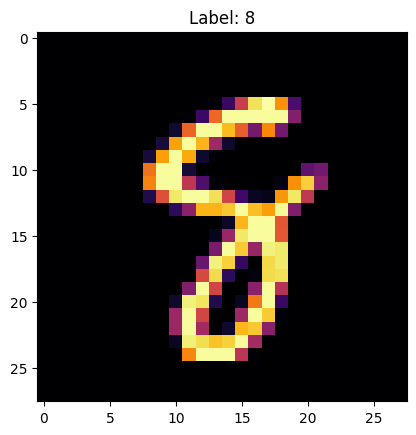

In [11]:
inputs, labels = next(iter(test_loader))

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == 8: #ra.randint(0, 9):
        img = inputs[ind].squeeze()
        break

plt.imshow(img, cmap="inferno")
plt.title(f"Label: {labels[ind].item()}")

In [12]:
pattern = re.compile(r'dig_(\d+)_ind(\d+)\.pt$')

files = []
for filename in os.listdir('stored_concepts'):
    match = pattern.search(filename)
    if match:
        dig = int(match.group(1))
        ind = int(match.group(2))
        files.append((dig, ind, filename))

files.sort()
used_indices = [ind for _, ind, _ in files]

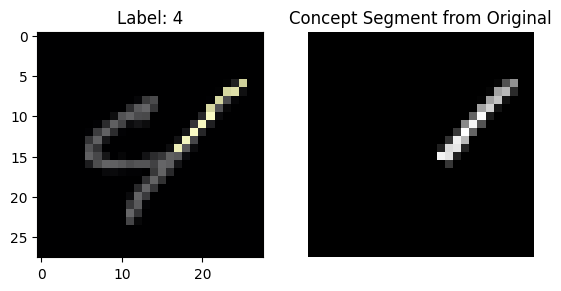

In [13]:
ind2 = 0

inputs, labels = next(iter(test_loader)) #in test_loader always same order if shuffle=False in batch
while True:
    rand_ind = ra.choice(used_indices)
    label, img = labels[rand_ind], inputs[rand_ind]
    if label == 4:
        break

label.item()

#creating lists of all tensors of all concepts stored:

pattern = re.compile(r'dig_(\d+)_ind(\d+)\.pt$')

files = []
for filename in os.listdir('stored_concepts'):
    match = pattern.search(filename)
    if match:
        dig = int(match.group(1))
        ind = int(match.group(2))
        files.append((dig, ind, filename))

files.sort()
used_indices = [ind for _, ind, _ in files]

tensor_groups_list = []
original_clusters_list = []

for idx in used_indices:
    data = torch.load(f"stored_concepts/concepts_dig_{labels[idx]}_ind{idx}.pt")
    tensor_groups = data['tensor_groups']
    original_clusters = data['original_clusters']

    tensor_groups_list.append(tensor_groups)
    original_clusters_list.append(original_clusters)
    
skeleton_tensors, original_clusters = tensor_groups_list[used_indices.index(rand_ind)], original_clusters_list[used_indices.index(rand_ind)]

plt.subplot(1, 2, 1)
plt.imshow(img.view(28, 28), cmap="gray") #or squeeze()
plt.imshow(skeleton_tensors[ind2].cpu().numpy(), cmap='inferno', alpha=0.6)
plt.title(f"Label: {label}")

plt.subplot(1, 2, 2)
plt.title('Concept Segment from Original')
plt.imshow(original_clusters[ind2], cmap='gray')

plt.axis('off')
plt.show()

ind2 = ind2 + 1 if ind2 < len(skeleton_tensors) - 1 else 0

In [14]:
len(skeleton_tensors)

15

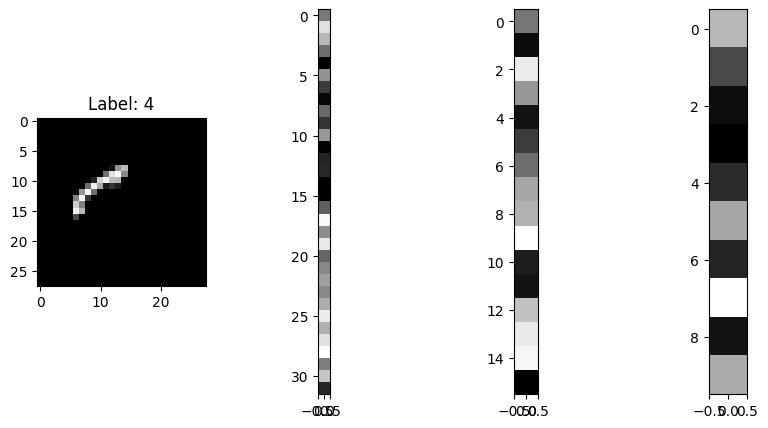

In [15]:
#forward pass returns out, [x0, x1, out]

def input_to_activation(inp):
    inp = inp.view(-1)
    net.eval()
    with torch.no_grad():
        _, activation_list = net(inp)

        return activation_list


#example to test:
act_list = input_to_activation(original_clusters_list[used_indices.index(rand_ind)][ind2].cuda())  #ra.randint(0, len(original_clusters_list)-1)][ra.randint(0, len(original_clusters)-1)])

plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(original_clusters_list[used_indices.index(rand_ind)][ind2], cmap="gray")
plt.title(f"Label: {labels[rand_ind]}")

for i, vector in enumerate(act_list):
    s = vector.shape[0]
    plt.subplot(1, 4, i+2)
    plt.imshow(vector.view(s, 1).cpu().detach().numpy(), cmap="gray")

ind2 = ind2 + 1 if ind2 < len(skeleton_tensors) - 1 else 0

In [16]:
#storing activations:

all_activations = []

for idx in used_indices:
    for idx2 in range(len(original_clusters_list[used_indices.index(idx)])):
        act_list = input_to_activation(original_clusters_list[used_indices.index(idx)][idx2].cuda())
        all_activations.append([act_list, (idx, idx2)])

In [28]:

def find_most_similar(all_activations, target, threshold):
    target_0, target_1, target_2 = target
    
    best_matches = []

    for i, triple in enumerate(all_activations):
        a0, a1, a2 = triple[0]

        d0 = torch.norm(a0 - target_0) #norm means euclidean dist
        d1 = torch.norm(a1 - target_1)
        d2 = torch.norm(a2 - target_2)
        total_distance = d0 + d1 + d2 #d0*0 + d1*0 + d2 is actually not too bad, has variation in hidden layer, but consistent in output, meaning different recombinations, same out

        if total_distance > threshold:
            continue
        else:
            best_matches.append([triple, total_distance, i])

    return best_matches


10

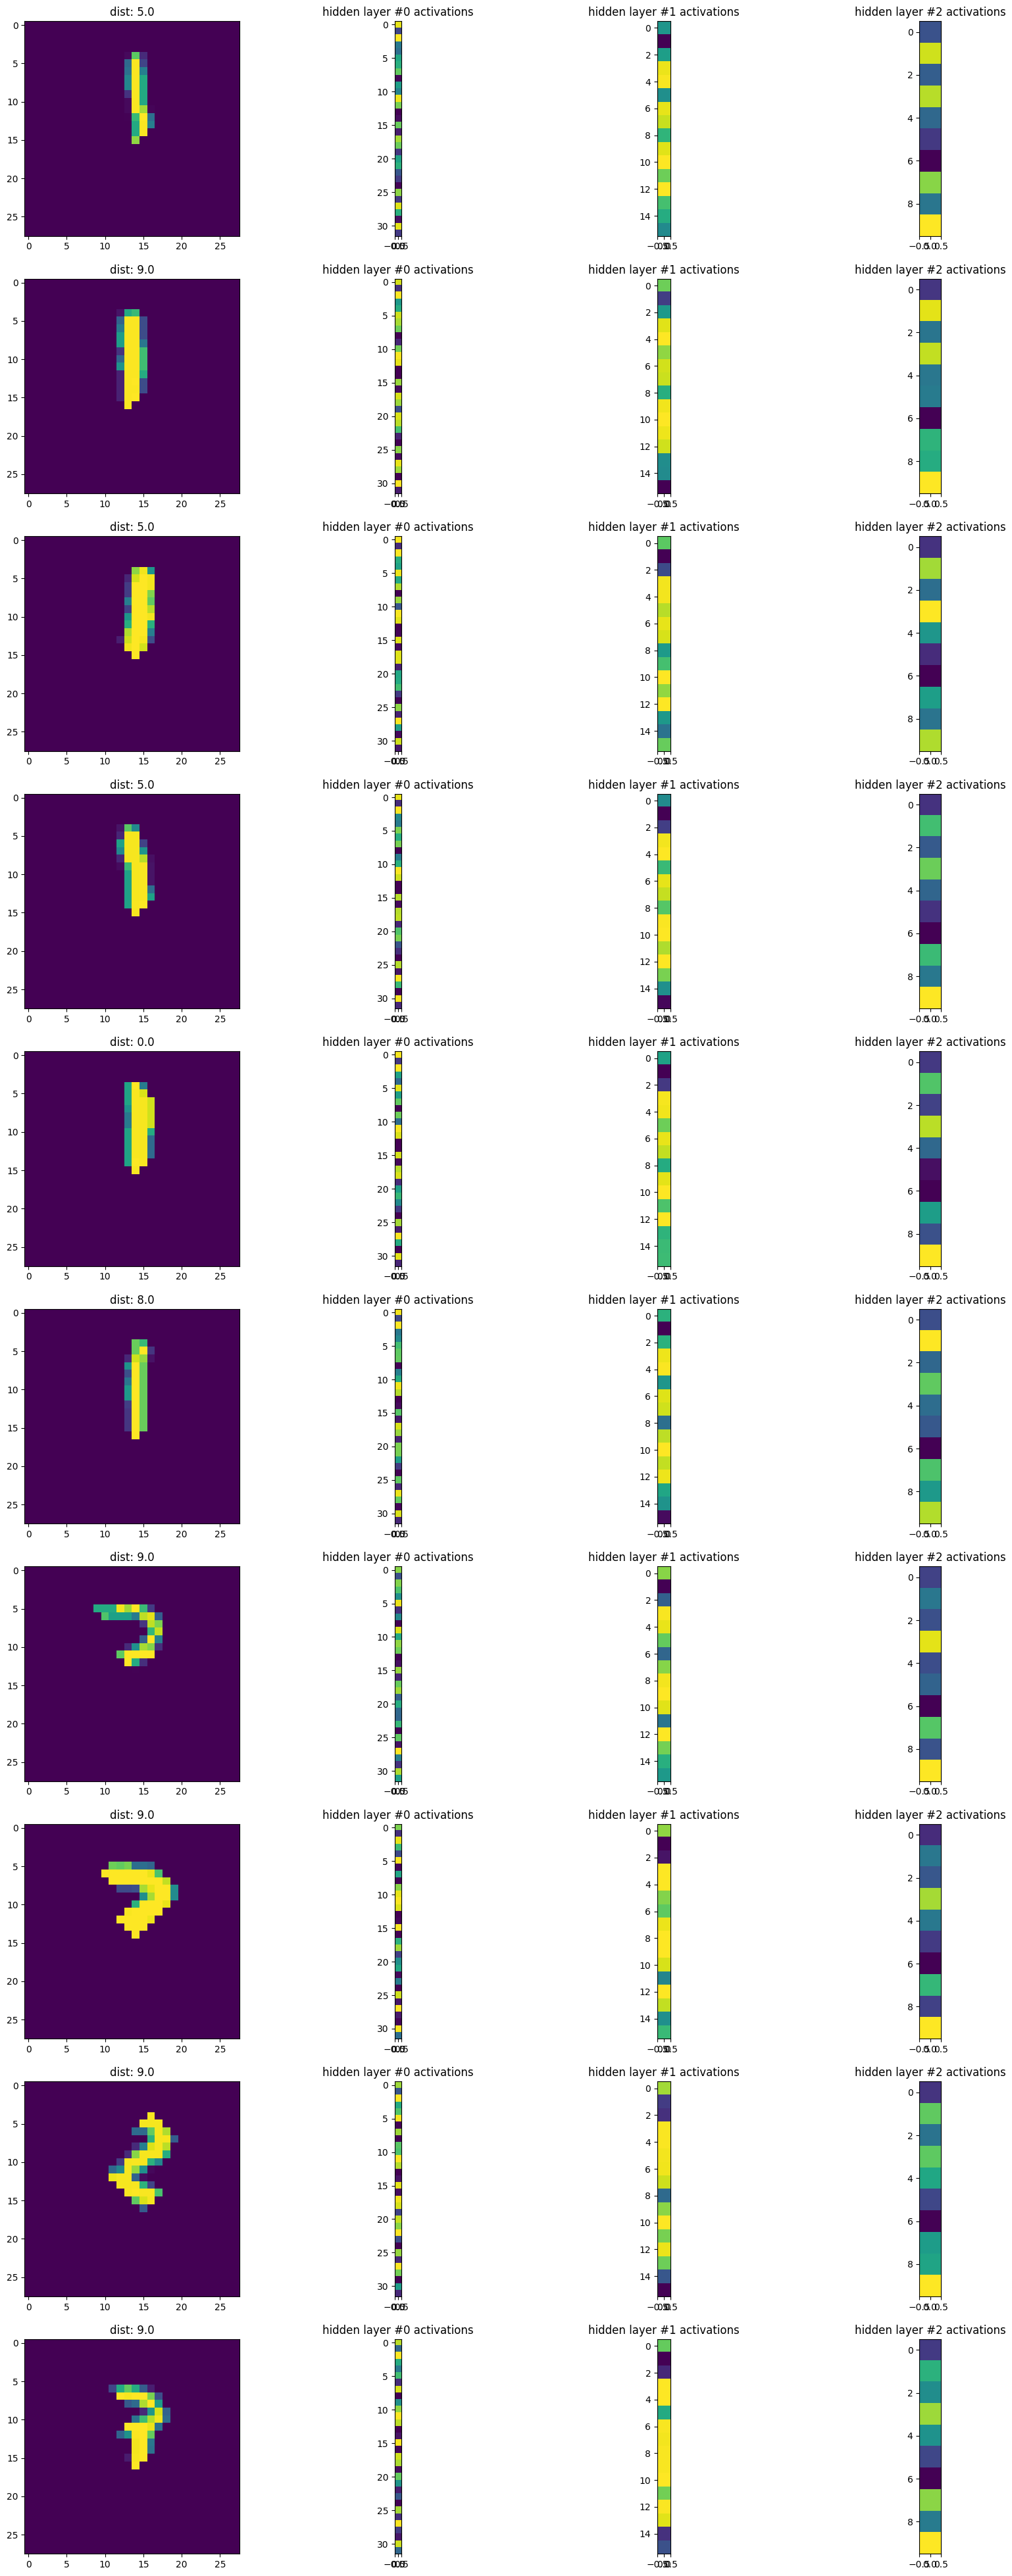

In [18]:

tar = all_activations[ra.randint(0, len(all_activations)-1)][0]
matches = find_most_similar(all_activations, tar, 10)
plt.figure(figsize=(20, len(matches)*5))

for i, match in enumerate(matches):
    triple = match[0]
    dist = match[1]
    ind = match[2]

    idx, idx2 = all_activations[ind][1]

    cluster = original_clusters_list[used_indices.index(idx)][idx2].cuda()

    plt.subplot(len(matches), 4, i*4+1)
    plt.imshow(cluster.cpu())
    plt.title(f"dist: {torch.round(dist)}")

    for j, vector in enumerate(triple[0]):
        s = vector.shape[0]
        plt.subplot(len(matches), 4, i*4+1+j+1)
        plt.imshow(vector.view(s, 1).cpu())
        plt.title(f"hidden layer #{j} activations")

len(matches)

#seems to be location boudn! perhaps the activations adhere to location because input neurons are based on location and only looking at similar activation means being dependant on that
#finding other relations where activations don't have to just be similar but have a specific new, learnt, relation could allow more precise recognition of low-level concepts, in any location
#angle is also a factor that is not currently generalised to, which is important as it would change the meaning of a feature (information it carries relevant to prediction)


In [32]:
import pygame

def draw_mnist_input(scale=20):
    pygame.init()
    size = 28
    window = pygame.display.set_mode((size*scale, size*scale))
    pygame.display.set_caption("Draw a digit (Press Enter to finish)")
    canvas = np.zeros((size, size), dtype=np.float32)

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                break
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_RETURN:
                    running = False
                    break
            elif pygame.mouse.get_pressed()[0]:
                x, y = pygame.mouse.get_pos()
                grid_x, grid_y = x // scale, y // scale
                if 0 <= grid_x < size and 0 <= grid_y < size:
                    canvas[grid_y, grid_x] = 1.0
                    for dx in [-1, 0, 1]:
                        for dy in [-1, 0, 1]:
                            nx, ny = grid_x + dx, grid_y + dy
                            if 0 <= nx < size and 0 <= ny < size:
                                canvas[ny, nx] = max(canvas[ny, nx], 0.5)

        for y in range(size):
            for x in range(size):
                val = int(canvas[y, x] * 255)
                pygame.draw.rect(window, (val, val, val), (x*scale, y*scale, scale, scale))

        pygame.display.flip()

    pygame.quit()
    return torch.tensor(canvas).unsqueeze(0)


custom_tensor = draw_mnist_input()
custom_tensor = custom_tensor / custom_tensor.max()
custom_tensor = custom_tensor.view(1, 1, 28, 28)
custom_tensor = F.avg_pool2d(custom_tensor, kernel_size=3, stride=1, padding=1)
pred = net(custom_tensor.view(1, -1).cuda())


custom_acivations = input_to_activation(custom_tensor.cuda())



In [33]:
import pygame
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

def draw_on_mnist(mnist_img, scale=20, threshold=2):
    pygame.init()
    size = 28
    screen = pygame.display.set_mode((size*scale, size*scale))
    pygame.display.set_caption("Draw to select parts (Enter = finish)")

    canvas = np.zeros((size, size), dtype=np.float32)
    img_np = mnist_img.squeeze().cpu().numpy()

    scaled_mnist = (img_np * 255).astype(np.uint8)
    scaled_mnist = np.repeat(np.repeat(scaled_mnist, scale, axis=0), scale, axis=1)

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                #pygame.quit(); return None
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_RETURN:
                    pass
            elif pygame.mouse.get_pressed()[0]:
                x, y = pygame.mouse.get_pos()
                gx, gy = x // scale, y // scale
                if 0 <= gx < size and 0 <= gy < size:
                    canvas[gy, gx] = 1.0
                    for dx in [-1, 0, 1]:
                        for dy in [-1, 0, 1]:
                            nx, ny = gx + dx, gy + dy
                            if 0 <= nx < size and 0 <= ny < size:
                                canvas[ny, nx] = 1.0

        for y in range(size):
            for x in range(size):
                val = int(img_np[y, x] * 255)
                if canvas[y, x] > 0:
                    color = (0, 255, 0)
                else:
                    color = (val, val, val)
                pygame.draw.rect(screen, color, (x*scale, y*scale, scale, scale))

        pygame.display.flip()

    pygame.quit()

    inv_draw = 1.0 - canvas
    dist = distance_transform_edt(inv_draw)
    mask = dist <= threshold

    segmented = img_np * mask

    plt.subplot(1,2,1)
    plt.imshow(img_np, cmap='gray'); plt.title("Original")

    plt.subplot(1,2,2)
    plt.imshow(segmented, cmap='gray'); plt.title("Segmented")
    plt.show()

    return torch.tensor(segmented, dtype=torch.float32).unsqueeze(0)


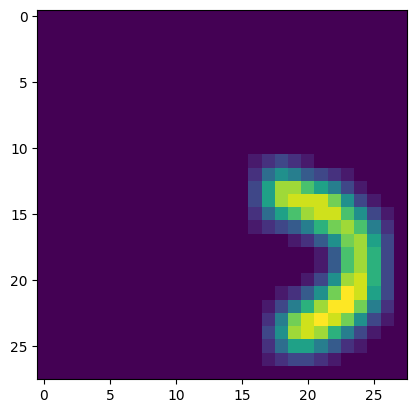

<Figure size 2000x0 with 0 Axes>

In [34]:
activation = input_to_activation(custom_tensor.view(28, 28).cuda())
matches = find_most_similar(all_activations, activation, 10)
matches = sorted(matches, key=lambda x: x[1])

plt.imshow(custom_tensor.view(28, 28))

plt.figure(figsize=(20, len(matches)*5))
for i, match in enumerate(matches):
    triple = match[0]
    dist = match[1]
    ind = match[2]

    idx, idx2 = all_activations[ind][1]

    cluster = original_clusters_list[used_indices.index(idx)][idx2].cuda()

    plt.subplot(len(matches), 4, i*4+1)
    plt.imshow(cluster.cpu())
    plt.title(f"dist: {torch.round(dist)}")

    for j, vector in enumerate(triple[0]):
        s = vector.shape[0]
        plt.subplot(len(matches), 4, i*4+1+j+1)
        plt.imshow(vector.view(s, 1).cpu())
        plt.title(f"hidden layer #{j} activations")
